# Task 3-4

Implement “sparse” and “denoising” autoencoders. Play with architecture (try both undercomplete and overcomplete, shallow and deep) and training hyper-parameters. Compare performance and visualize the results (based on several test samples).   

In [37]:
from tensorflow.python.keras.models import Sequential, load_model, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, Input, Reshape
from tensorflow.python.keras import utils, regularizers
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.keras.layers import BatchNormalization, GaussianNoise
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os

In [12]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [13]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [14]:
X_train.shape

(60000, 28, 28)

In [18]:
num_classes = 10
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [26]:
# y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

### Sparse autoencoder

In [17]:
def create_sparse_model(architecture='undercomplete', l1_penalty=0.0001, hidden_units=[128], dropout_rate=0.0):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Flatten()(input_img)
    for units in hidden_units:
        x = Dense(units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    
    # Sparsity constraint
    if architecture == 'overcomplete':
        encoded = Dense(units=hidden_units[-1]*2, activation='relu')(x)
    else:
        encoded = Dense(units=hidden_units[-1], activation='relu')(x)

    x = Dense(units=hidden_units[-1], activation='relu', activity_regularizer= regularizers.l1(l1_penalty))(encoded)
    for units in reversed(hidden_units[:-1]):
        x = Dense(units, activation='relu', activity_regularizer=regularizers.l1(l1_penalty))(x)
        x = Dropout(dropout_rate)(x)
    
    # Decoder
    x = Dense(units=784, activation='sigmoid')(x)
    decoded = Reshape(input_shape)(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Encoder model
    encoder = Model(input_img, encoded)

    # Decoder model
    encoded_input = Input(shape=(hidden_units[-1],))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder #, encoder, decoder


In [22]:
train_params = [
    {
        'name': 'sparse_undercmplt_shallow',
        'architecture': 'undercomplete',
        'l1_penalty': 0.0001,
        'hidden_units': [256, 128],
        'dropout_rate': 0.2,
        'batch_size': 64,
        'epochs': 5,
    },
    {
        'name': 'sparse_undercmplt_deep',
        'architecture': 'undercomplete',
        'l1_penalty': 0.0001,
        'hidden_units': [512, 256, 128, 64],
        'dropout_rate': 0.4,
        'batch_size': 64,
        'epochs': 5,
    },
    {
        'name': 'sparse_overcomplete_shallow',
        'architecture': 'overcomplete',
        'l1_penalty': 0.0001,
        'hidden_units': [256, 128],
        'dropout_rate': 0.2,
        'batch_size': 64,
        'epochs': 5,
    },
    {
        'name': 'sparse_overcomplete_deep',
        'architecture': 'overcomplete',
        'l1_penalty': 0.0001,
        'hidden_units': [512, 256, 128, 64],
        'dropout_rate': 0.5,
        'batch_size': 64,
        'epochs': 5,
    },
]

In [23]:
n = 10 # examples to show

In [29]:
def plot_enc_dec(imgs, enc_imgs, dec_imgs, title=''):
    fig, ax = plt.subplots(3, n, figsize=(16, 4))
    for i in range(n):
        ax[0][i].imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax[1][i].imshow(enc_imgs[i].reshape(28, 28))
        plt.gray()
        ax[2][i].imshow(dec_imgs[i].reshape(28, 28))
        plt.gray()
    fig.suptitle(title)
    plt.show()


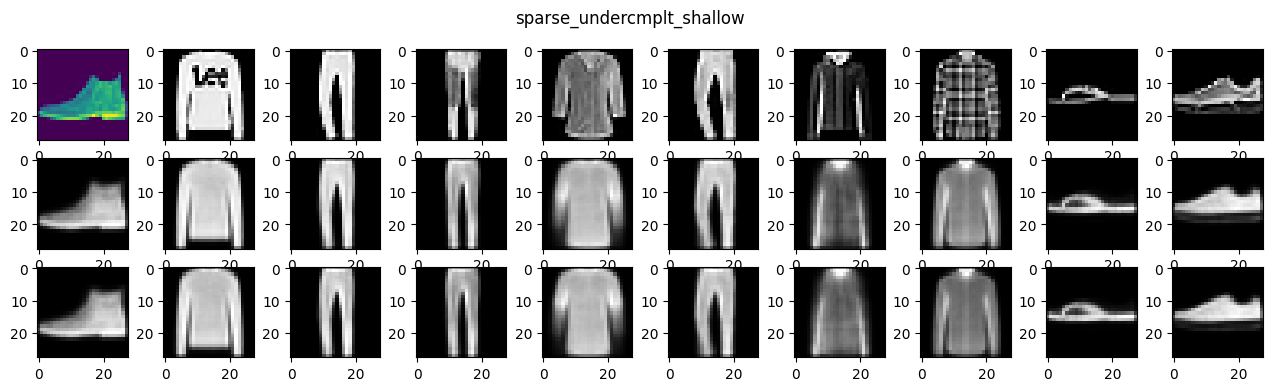

Epoch 1/5
938/938 [==============================] - 13s 13ms/step - loss: 0.4108 - val_loss: 0.3769
Epoch 2/5
938/938 [==============================] - 12s 12ms/step - loss: 0.3693 - val_loss: 0.3656
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.3596 - val_loss: 0.3570
Epoch 4/5
938/938 [==============================] - 12s 12ms/step - loss: 0.3544 - val_loss: 0.3527
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.3509 - val_loss: 0.3505
INFO:tensorflow:Assets written to: ./models/sparse_undercmplt_deep\assets


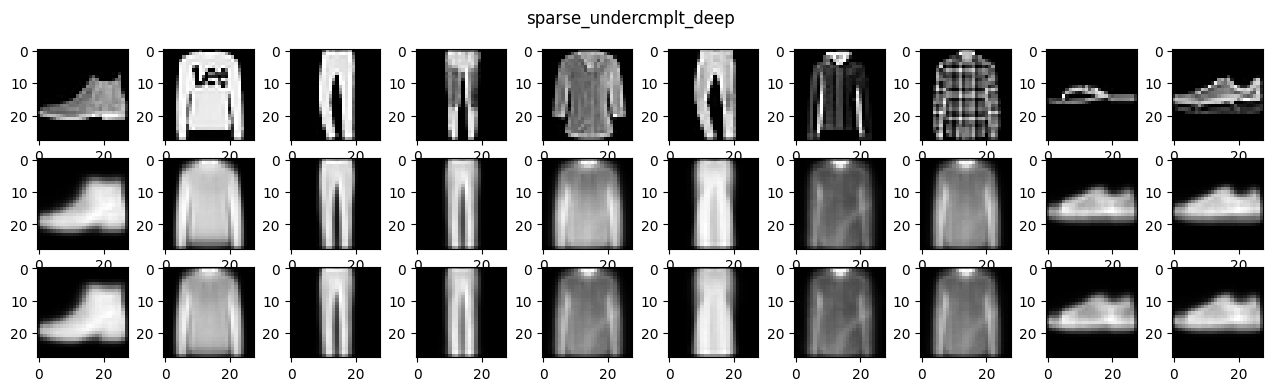

Epoch 1/5
938/938 [==============================] - 7s 7ms/step - loss: 0.3521 - val_loss: 0.3193
Epoch 2/5
938/938 [==============================] - 7s 7ms/step - loss: 0.3195 - val_loss: 0.3095
Epoch 3/5
938/938 [==============================] - 6s 7ms/step - loss: 0.3129 - val_loss: 0.3058
Epoch 4/5
938/938 [==============================] - 6s 7ms/step - loss: 0.3089 - val_loss: 0.3018
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.3064 - val_loss: 0.3010
INFO:tensorflow:Assets written to: ./models/sparse_overcomplete_shallow\assets


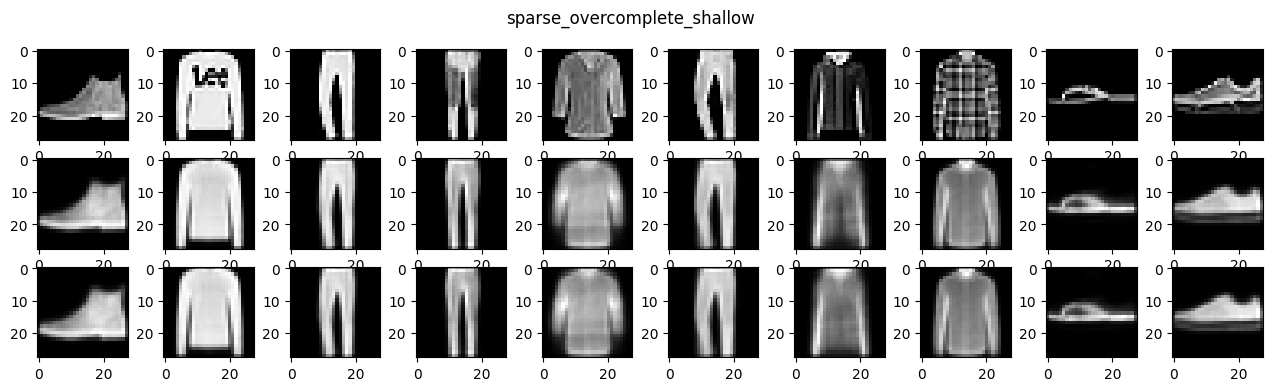

Epoch 1/5
938/938 [==============================] - 14s 14ms/step - loss: 0.4292 - val_loss: 0.4222
Epoch 2/5
938/938 [==============================] - 13s 14ms/step - loss: 0.3962 - val_loss: 0.4140
Epoch 3/5
938/938 [==============================] - 13s 14ms/step - loss: 0.3917 - val_loss: 0.4029
Epoch 4/5
938/938 [==============================] - 14s 15ms/step - loss: 0.3882 - val_loss: 0.4133
Epoch 5/5
938/938 [==============================] - 13s 14ms/step - loss: 0.3853 - val_loss: 0.4023
INFO:tensorflow:Assets written to: ./models/sparse_overcomplete_deep\assets


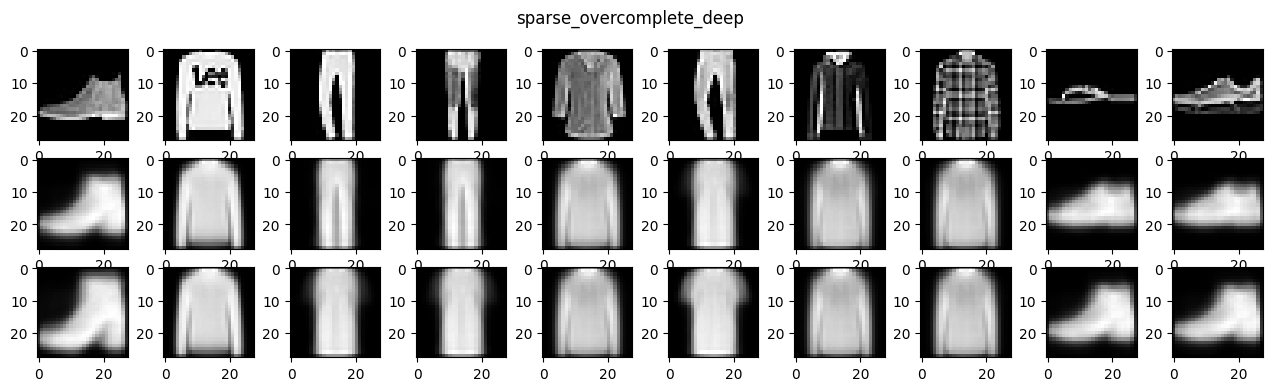

In [30]:
for params in train_params:
    if not os.path.isdir(f"./models/{params['name']}"):
        ae = create_sparse_model(params['architecture'], params['l1_penalty'], params['hidden_units'], params['dropout_rate'])
        history = ae.fit(X_train, X_train, batch_size=params['batch_size'], epochs=params['epochs'], validation_data=(X_test, X_test), callbacks=[early_stop])
        ae.save(f"./models/{params['name']}")
    else:
        ae = load_model(f"./models/{params['name']}")
        
    to_predict = X_test[:n]
    
    encoded_imgs = ae.predict(to_predict)
    # Decode encoded images back to original size
    decoded_imgs = ae.predict(encoded_imgs)
    
    plot_enc_dec(to_predict, encoded_imgs, decoded_imgs, params['name'])
